Studying the effect of asymmetrical variability on back propagation
# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numba import njit, cuda

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [5]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Training software BP with new subsampled version of MNIST

In [6]:
def params_init(newShape, midLayerSize, seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(midLayerSize,newShape) - 0.5
  b1 = np.random.rand(midLayerSize,1) - 0.5
  W2 = np.random.rand(10,midLayerSize) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

In [7]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [8]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  return np.exp(Z) / np.sum(np.exp(Z),0)
  #Z = Z-np.max(Z, axis=0)
  #return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre + 10e-16)), axis = 0)
  return loss

In [9]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

In [10]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

In [11]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [12]:
def batch_grad_descent(X,Y,batchsize,iter, lr, midLayerSize, seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}
  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(63000//batchsize): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*batchsize: (j+1)*batchsize].T,Y[j*batchsize: (j+1)*batchsize]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score} Val loss: {np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')
      # plt.figure()
      # plt.hist(W1.flatten())

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [13]:
_, _, _, _, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,batchsize = 630,iter=100, lr=0.1,midLayerSize = 10, seed = 47,print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 65.67142857142856
Val accuracy: 64.47142857142858 Val loss: 6653.281599688319
Iteration: 2
Train accuracy: 69.95396825396826
Val accuracy: 69.19999999999999 Val loss: 5723.207730349599
Iteration: 3
Train accuracy: 71.65079365079366
Val accuracy: 71.14285714285714 Val loss: 5342.6829474595215
Iteration: 4
Train accuracy: 72.63809523809523
Val accuracy: 72.17142857142858 Val loss: 5110.70009579257
Iteration: 5
Train accuracy: 73.4904761904762
Val accuracy: 73.12857142857143 Val loss: 4928.86631570027
Iteration: 6
Train accuracy: 74.28095238095239
Val accuracy: 74.02857142857144 Val loss: 4764.495329503857
Iteration: 7
Train accuracy: 74.98412698412699
Val accuracy: 74.7 Val loss: 4633.007240898238
Iteration: 8
Train accuracy: 75.53650793650793
Val accuracy: 75.34285714285714 Val loss: 4518.873969677319
Iteration: 9
Train accuracy: 76.11904761904762
Val accuracy: 76.0 Val loss: 4412.086344467167
Iteration: 10
Train accuracy: 76.7
Val accurac

### Generic functions related to variability

In [14]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
#add clipping here
# def roundArbitrary(weightArray, step):
#   weightArrayDiv = weightArray / step
#   weightArrayDiv = np.round(weightArrayDiv)
#   return weightArrayDiv*step
def roundArbitrary(weightArray, step, wRange):#updates function with clipping
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

In [15]:
def initMosParam(shape, mu, sigma, vDD, precision, asym, k=10000):
    #modelling both Ion and Ioff  = I0*exp(Vgs-Vth/(eta*kB*T)),
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)
    I0On = 1e+06
    I0Off = I0On/k
    #eta = 
    #kB = 1.3806452e10-23
    #T = 300
    VT = 0.026*1.5#should be eqaul to eta x kB x T

    #Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    Vth[Vth<=0] = 10e-10

    #iOn = ((vDD - Vth)**2)*I0On#scaling the current according to Ioff values arbitraryfor now!!
    iOn = I0On * np.exp((0 - Vth)/(VT))
    #iOn = I0On * np.ones_like(Vth)



    #iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))
    iOnNominal = np.sum(iOn)/(dim1*dim2*precision)
    #Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    #iOff = np.random.uniform(low=0, high=1e-8, size = sizeI)#no negative value
    iOff = I0Off * np.exp((0 - Vth)/(VT))
    #iOff = I0Off * np.ones_like(Vth)


    Vth_asym = np.random.normal(loc = Vth, scale = sigma/asym)
    Vth_asym[Vth_asym<=0] = 10e-10
    iOnAsym = I0On * np.exp((0 - Vth_asym)/(VT))
    iOnNominalAsym = np.sum(iOnAsym)/(dim1*dim2*precision)
    iOffAsym = I0Off * np.exp((0 - Vth_asym)/(VT))
    #return these
    return (iOn, iOnNominal, iOff), (iOnAsym, iOnNominalAsym, iOffAsym)

In [16]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps, wRange):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  #clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights
  #updating the above to the actual round function.
  clippedWeightIndexArray = (roundArbitrary(weightArray, step, wRange)/step).astype(np.int64)
  clippedWeightIndexArray = np.abs(clippedWeightIndexArray)

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray +=  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)

  
  analogWeightArray  = np.multiply(np.sign(weightArray), analogWeightArray)

  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [25]:
def batch_grad_descent_with_var(X,Y, batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, asym, onoff,seed = None, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = seed)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)

  #blind updates
  W1bu = W1.copy()
  b1bu = b1.copy()
  W2bu = W2.copy()
  b2bu = b2.copy()


  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  W1Currents, W1CurrentsAsym = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, asym = asym, k =onoff)#k = Ion/Ioff
  b1Currents, b1CurrentsAsym = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, asym = asym,k =onoff)
  W2Currents, W2CurrentsAsym = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, asym = asym,k =onoff)
  b2Currents, b2CurrentsAsym = initMosParam((10, 1), mu, sigma, vDD, precision, asym = asym,k =onoff)




  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(63000//batchsize): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batchsize = 630
      X1, Y1 = shuffle(X[:, j*batchsize: (j+1)*batchsize].T,Y[j*batchsize: (j+1)*batchsize]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
    
      


      #blind updates
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)

      W1varocAsym = weightTransformWithVariability(W1bu, W1CurrentsAsym, precision, step, discreteSteps, wRange)
      b1varocAsym = weightTransformWithVariability(b1bu, b1CurrentsAsym, precision, step, discreteSteps, wRange)
      W2varocAsym = weightTransformWithVariability(W2bu, W2CurrentsAsym, precision, step, discreteSteps, wRange)
      b2varocAsym = weightTransformWithVariability(b2bu, b2CurrentsAsym, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      dW1bu, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1varocAsym, W2varocAsym, X1, Y1)

      W1bu, b1bu, W2bu, b2bu = param_update(W1varoc, b1varoc, W2varoc,b2varoc, dW1bu, db1, dW2, db2, lr = lr)

      W1bu = roundArbitrary(W1bu, step, wRange)#weights have to maintained as their digitized versions
      b1bu = roundArbitrary(b1bu, step, wRange)
      W2bu = roundArbitrary(W2bu, step, wRange)
      b2bu = roundArbitrary(b2bu, step, wRange)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      buAccTrainAcc = accuracy(predictions(A2_train), Y)
      buTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      buAccValAcc = accuracy(predictions(A2_val), y_val)
      buValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


  
      train_acc.append(buAccTrainAcc)
      train_loss.append(buTrainLoss)
      print(f'Training :: Blind : {buAccTrainAcc}')


      val_acc.append(buAccValAcc)
      val_loss.append(buValLoss)
      print(f'Validation  :: Blind : {buAccValAcc} :: Blind Loss : {buValLoss}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [18]:
mu = 0.7
sigma = 0.001
onoff = 10000
asym = 1000000000000
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10 #10
lr = 0.1 #0.1
batchsize = 630

In [40]:
W1, b1, W2, b2, train_acc_quant, val_acc_quant, train_loss, val_loss, sum_weights = batch_grad_descent_with_var(x_train,y_train,batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, asym, onoff,seed = 47,print_op=1)

Params Initialised
Iteration: 1
Training :: Blind : 52.98571428571428
Validation  :: Blind : 53.542857142857144 :: Blind Loss : 9025.102135733043
Iteration: 2
Training :: Blind : 58.12539682539683
Validation  :: Blind : 58.4 :: Blind Loss : 8142.630078813778
Iteration: 3
Training :: Blind : 58.56031746031746
Validation  :: Blind : 59.18571428571428 :: Blind Loss : 7831.58427211157
Iteration: 4
Training :: Blind : 58.82222222222222
Validation  :: Blind : 59.357142857142854 :: Blind Loss : 7754.658234508883
Iteration: 5
Training :: Blind : 58.4936507936508
Validation  :: Blind : 59.17142857142858 :: Blind Loss : 7777.486279363467
Iteration: 6
Training :: Blind : 58.8952380952381
Validation  :: Blind : 59.64285714285714 :: Blind Loss : 7740.1335879596545
Iteration: 7
Training :: Blind : 58.73968253968253
Validation  :: Blind : 59.42857142857143 :: Blind Loss : 7742.1563556262845
Iteration: 8
Training :: Blind : 59.112698412698414
Validation  :: Blind : 59.5 :: Blind Loss : 7701.5758422391

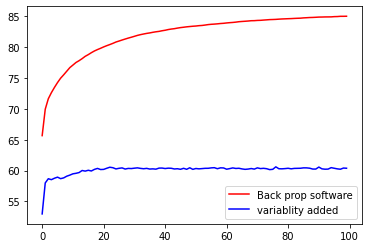

In [20]:
plt.plot(train_accBP, 'r', label = "Back prop software")
plt.plot(train_acc_quant, 'b', label = "variablity added")
plt.legend()

## Trying different assymetries(12bits - 0.001var-10000onoff)

In [21]:
mu = 0.7
sigma = 0.001
onoff = 10000
asym = 100000
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 100
midLayerSize = 10 #10
lr = 0.1 #0.1
batchsize = 630

In [27]:
trainAccAsym = []
valAccAsym = []
trainLossAsym = []
valLossAsym = []
Asym = [100, 60, 50 ,30, 10, 5, 3, 1]
for asym in Asym:
    W1, b1, W2, b2, train_acc_quanttemp, val_acc_quanttemp, train_losstemp, val_losstemp, sum_weights = batch_grad_descent_with_var(x_train,y_train,batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, asym, onoff,seed = 47,print_op=1)
    trainAccAsym.append(train_acc_quanttemp)
    valAccAsym.append(val_acc_quanttemp)
    trainLossAsym.append(train_losstemp)
    valLossAsym.append(val_losstemp)

Params Initialised
Iteration: 1
Training :: Blind : 52.99047619047619
Validation  :: Blind : 53.58571428571428 :: Blind Loss : 9035.551094042095
Iteration: 2
Training :: Blind : 57.960317460317455
Validation  :: Blind : 58.099999999999994 :: Blind Loss : 8157.605421035234
Iteration: 3
Training :: Blind : 58.63809523809523
Validation  :: Blind : 59.199999999999996 :: Blind Loss : 7829.209443023833
Iteration: 4
Training :: Blind : 58.56349206349206
Validation  :: Blind : 59.0 :: Blind Loss : 7789.403957224436
Iteration: 5
Training :: Blind : 58.74444444444444
Validation  :: Blind : 59.357142857142854 :: Blind Loss : 7752.434348194175
Iteration: 6
Training :: Blind : 58.939682539682536
Validation  :: Blind : 59.55714285714285 :: Blind Loss : 7719.630647519686
Iteration: 7
Training :: Blind : 58.62380952380952
Validation  :: Blind : 59.457142857142856 :: Blind Loss : 7758.696337531579
Iteration: 8
Training :: Blind : 59.13333333333334
Validation  :: Blind : 59.72857142857143 :: Blind Loss 

Text(0.5, 1.0, 'Dip in accuracy due to assymetry in the case of BP(12 bit arch, var = 0.001)')

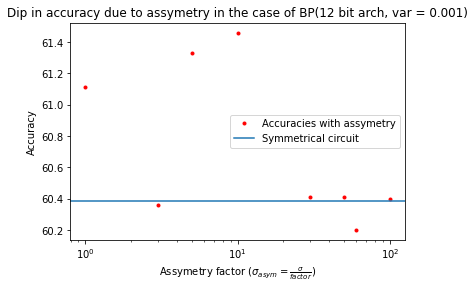

In [35]:
finAccforPlot = []
for i in trainAccAsym:
    finAccforPlot.append(i[-1])
plt.plot(Asym, finAccforPlot, 'r.', label = "Accuracies with assymetry")
plt.axhline(train_acc_quant[-1], label = "Symmetrical circuit")
plt.xscale("log")
plt.xlabel(r"Assymetry factor ($\sigma_{asym} = \frac{\sigma}{factor} $)")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Dip in accuracy due to assymetry in the case of BP(12 bit arch, var = 0.001)")

In [47]:
trainAccAsymStatTotal = []
valAccAsymStatTotal = []
trainLossAsymStatTotal = []
valLossAsymStatTotal= []
Seeding = np.random.randint(10, 100, 5)
Asym = [100, 60, 50 ,30, 10, 5, 3, 1]
for asym in Asym:
    trainAccAsymStat = []
    valAccAsymStat = []
    trainLossAsymStat = []
    valLossAsymStat = []
    for seed in Seeding:
        W1, b1, W2, b2, train_acc_quanttemp, val_acc_quanttemp, train_losstemp, val_losstemp, sum_weights = batch_grad_descent_with_var(x_train,y_train,batchsize,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, asym, onoff, seed = seed ,print_op=1)
        trainAccAsymStat.append(train_acc_quanttemp)
        valAccAsymStat.append(val_acc_quanttemp)
        trainLossAsymStat.append(train_losstemp)
        valLossAsymStat.append(val_losstemp)
    trainAccAsymStatTotal.append(trainAccAsymStat)
    valAccAsymStatTotal.append(valAccAsymStat)
    trainLossAsymStatTotal.append(trainLossAsymStat)
    valLossAsymStatTotal.append(valLossAsymStat)

Params Initialised
Iteration: 1
Training :: Blind : 48.12698412698413
Validation  :: Blind : 48.5 :: Blind Loss : 10521.294039489092
Iteration: 2
Training :: Blind : 53.21269841269841
Validation  :: Blind : 53.85714285714286 :: Blind Loss : 9577.887197802338
Iteration: 3
Training :: Blind : 54.75714285714286
Validation  :: Blind : 55.285714285714285 :: Blind Loss : 9192.230168858734
Iteration: 4
Training :: Blind : 55.74761904761905
Validation  :: Blind : 55.91428571428572 :: Blind Loss : 8930.159920995946
Iteration: 5
Training :: Blind : 56.582539682539675
Validation  :: Blind : 56.628571428571426 :: Blind Loss : 8728.061408209818
Iteration: 6
Training :: Blind : 56.96825396825397
Validation  :: Blind : 56.885714285714286 :: Blind Loss : 8634.330740703728
Iteration: 7
Training :: Blind : 57.18095238095238
Validation  :: Blind : 56.95714285714286 :: Blind Loss : 8576.600805842301
Iteration: 8
Training :: Blind : 57.33809523809524
Validation  :: Blind : 57.371428571428574 :: Blind Loss 

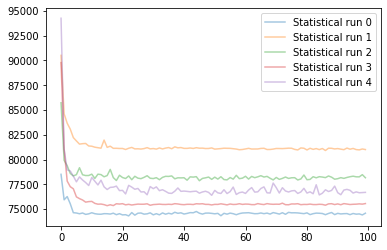

In [44]:
ind = 0 
for i in trainLossAsymStat:
    plt.plot(i, alpha=0.4, label = f"Statistical run {ind}")
    ind +=1
plt.legend()

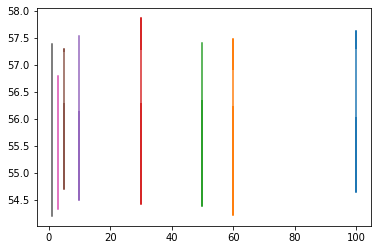

In [51]:
ind = 0 
for j in trainAccAsymStatTotal:
    finAccforPlot = []
    for i in j:
        finAccforPlot.append(i[-1])
    plt.plot([Asym[ind]]*5, finAccforPlot)
    ind +=1

In [50]:
[1]*5

[1, 1, 1, 1, 1]